# Risk-Based Portfolios (RBP)

This notebook demonstrates various risk-based portfolio construction methods including:
- Inverse Volatility Portfolio (IVP)
- Risk Parity Portfolio (RPP) variants
- Maximum Sharpe Ratio Portfolio (MSRP)
- Most Diversified Portfolio (MDP)
- Global Minimum Variance Portfolio (GMVP)
- Maximum Decorrelation Portfolio (MDCP)

In [23]:
# Import required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import cvxpy as cp
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

from helpers import get_yahoo_data,create_resampled_datasets

## Data Loading and Preprocessing

Data shape: (60, 10)
Date range: 2020-11-01 00:00:00 to 2025-10-01 00:00:00

First few rows:
Ticker              BA         GE        WMT         JPM         MCD  \
Date                                                                   
2020-11-01  210.710007  49.609852  47.507450  104.034264  193.989548   
2020-12-01  214.059998  52.631271  44.820984  112.144844  192.575806   
2021-01-01  194.190002  52.094368  43.842640  113.556908  186.526947   
2021-02-01  212.009995  61.166969  40.544060  130.819351  185.001266   
2021-03-01  254.720001  64.044838  42.388405  135.317169  202.393127   

Ticker            GOOG        AMZN        META        AAPL        NFLX  
Date                                                                    
2020-11-01   87.438637  158.401993  275.273010  115.802063  490.700012  
2020-12-01   86.998650  162.846497  271.486359  129.292618  540.729980  
2021-01-01   91.163155  160.309998  256.747223  128.581314  532.390015  
2021-02-01  101.150803  154.646500  2

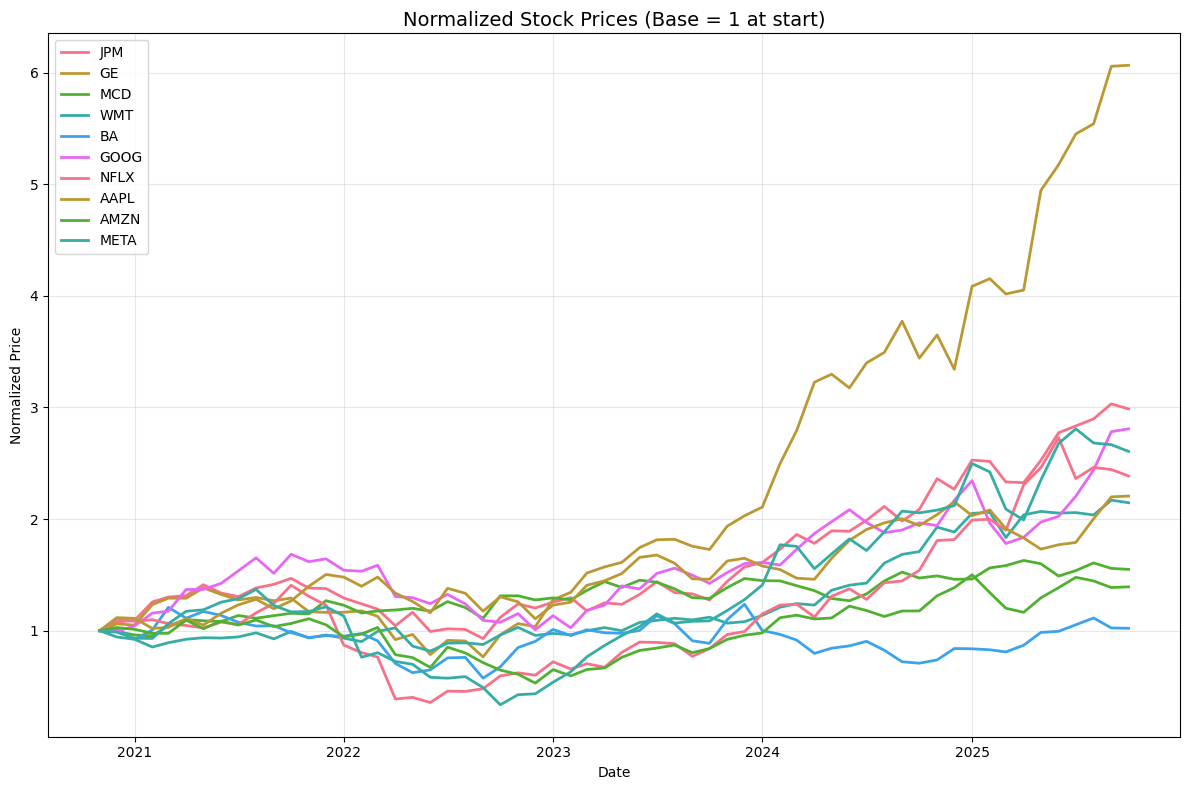

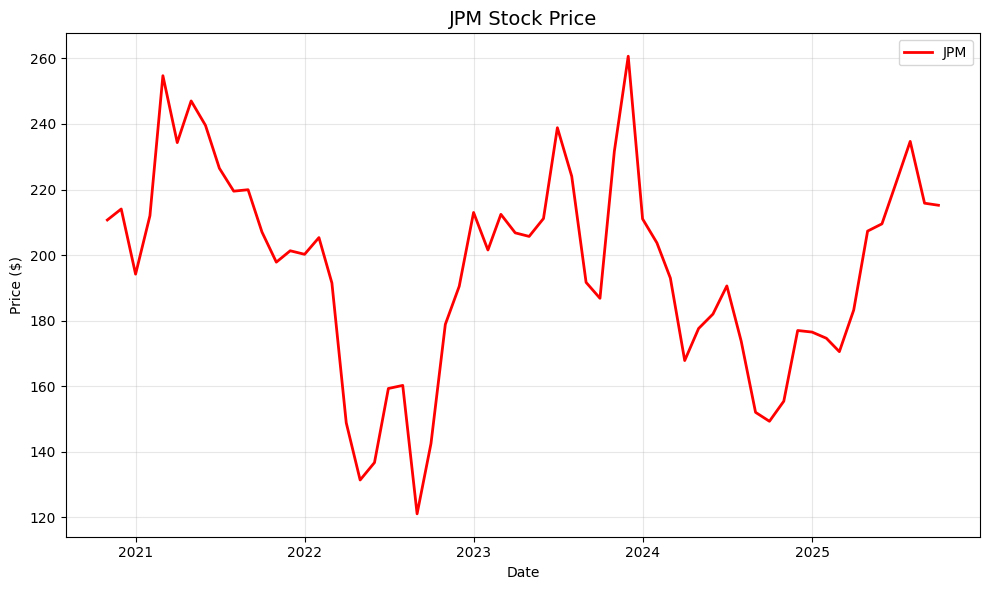


Training set: 41 observations
Test set: 18 observations

Estimated parameters from training data:
Expected returns (annualized):
Ticker
BA     -0.2885
GE      1.4854
WMT     0.2620
JPM     0.7329
MCD     0.3887
GOOG    0.7940
AMZN    0.1264
META    0.5597
AAPL    0.4803
NFLX    0.1462
dtype: float64

Volatilities (annualized):
[0.8328 0.6951 0.3897 0.5378 0.3566 0.5717 0.6944 0.979  0.5442 1.109 ]

Correlation matrix:
Ticker     BA     GE    WMT    JPM    MCD   GOOG   AMZN   META   AAPL   NFLX
Ticker                                                                      
BA      1.000  0.536  0.134  0.486  0.502  0.347  0.315  0.207  0.393  0.405
GE      0.536  1.000  0.242  0.729  0.398  0.532  0.510  0.265  0.413  0.569
WMT     0.134  0.242  1.000  0.077  0.388  0.236  0.270  0.219  0.376  0.158
JPM     0.486  0.729  0.077  1.000  0.408  0.335  0.238  0.201  0.221  0.520
MCD     0.502  0.398  0.388  0.408  1.000  0.248  0.206  0.107  0.612  0.257
GOOG    0.347  0.532  0.236  0.335  0.

In [24]:

stock_list = ["JPM","GE","MCD","WMT","BA", "GOOG", "NFLX", "AAPL", "AMZN", "META"]  # FAANG stocks

to_date = datetime.now()  # today
from_date = to_date - timedelta(days=5*365)  # past five years
begin_date = from_date.strftime('%Y-%m-%d')
end_date = to_date.strftime('%Y-%m-%d')
interval = '1mo'  #'1wk'  # weekly frequency

print(f"Downloading stock data for {stock_list} from {begin_date} to {end_date}...")

# Download monthly data from Yahoo Finance
data = get_yahoo_data(
        ticker_list=stock_list,
        start_date=begin_date,
        end_date=end_date,
        interval=interval
    )

# Extract adjusted close prices
prices = data.xs('Adj Close', level=1, axis=1).copy()
#prices.columns = stock_list

print(f"Data shape: {prices.shape}")
print(f"Date range: {prices.index[0]} to {prices.index[-1]}")
print("\nFirst few rows:")
print(prices.head())
print("\nLast few rows:")
print(prices.tail())

# Compute log returns using pandas vectorized operations
log_returns = np.log(prices / prices.shift(1)).dropna()

NS = len(stock_list)  # number of stocks
NT = len(log_returns)  # number of time periods

print(f"\nLog returns shape: {log_returns.shape}")
print("\nLog returns summary:")
print(log_returns.describe())

# Plot normalized prices
plt.figure(figsize=(12, 8))
normalized_prices = prices / prices.iloc[0]
for stock in stock_list:
    plt.plot(normalized_prices.index, normalized_prices[stock], label=stock, linewidth=2)
plt.title('Normalized Stock Prices (Base = 1 at start)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

first_stock = stock_list[0] 

# Plot individual stock (Amazon as example)
plt.figure(figsize=(10, 6))
plt.plot(prices.index, prices.iloc[:, 0], color='red', linewidth=2, label=first_stock)
plt.legend()
plt.title(f'{first_stock} Stock Price', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Split data into training and test sets
T_trn = int(0.7 * NT)  # 70% for training
log_returns_train = log_returns.iloc[:T_trn]
log_returns_test = log_returns.iloc[T_trn:]

print(f"\nTraining set: {len(log_returns_train)} observations")
print(f"Test set: {len(log_returns_test)} observations")

# Estimate parameters from training data
mu = log_returns_train.mean()
Sigma = log_returns_train.cov()
vol = np.sqrt(np.diag(Sigma))

print("\nEstimated parameters from training data:")
print(f"Expected returns (annualized):")
print((mu * 52).round(4))  # Weekly to annual
print(f"\nVolatilities (annualized):")
print((vol * np.sqrt(52)).round(4))
print(f"\nCorrelation matrix:")
print(log_returns_train.corr().round(3))

## Portfolio Utility Functions

In [25]:
def portfolio_risk_contribution(weights, Sigma):
    """
    Calculate risk contributions for a portfolio
    """
    weights = np.array(weights)
    portfolio_vol = np.sqrt(weights.T @ Sigma @ weights)
    marginal_contrib = (Sigma @ weights) / portfolio_vol
    risk_contrib = weights * marginal_contrib
    relative_risk_contrib = risk_contrib / portfolio_vol
    
    return {
        'portfolio_volatility': portfolio_vol,
        'marginal_contribution': marginal_contrib,
        'risk_contribution': risk_contrib,
        'relative_risk_contribution': relative_risk_contrib
    }

def plot_portfolio_weights(weights, labels=None, title='Portfolio Weights'):
    """
    Create a bar plot of portfolio weights
    """
    if isinstance(weights, pd.DataFrame):
        # Multiple portfolios
        fig, ax = plt.subplots(figsize=(12, 8))
        weights.plot(kind='bar', ax=ax, width=0.8)
        plt.title(title, fontsize=14)
        plt.xlabel('Assets')
        plt.ylabel('Weight')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.tight_layout()
    else:
        # Single portfolio
        if labels is None:
            labels = [f'Asset {i+1}' for i in range(len(weights))]
        
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.bar(labels, weights, alpha=0.7)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Assets')
        ax.set_ylabel('Weight')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_risk_contributions(weights, Sigma, labels=None, title='Risk Contributions'):
    """
    Plot risk contributions for a portfolio
    """
    risk_data = portfolio_risk_contribution(weights, Sigma)
    if labels is None:
        labels = [f'Asset {i+1}' for i in range(len(weights))]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Portfolio weights
    ax1.bar(labels, weights, alpha=0.7, color='skyblue')
    ax1.set_title('Portfolio Weights')
    ax1.set_ylabel('Weight')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Risk contributions
    ax2.bar(labels, risk_data['relative_risk_contribution'], alpha=0.7, color='lightcoral')
    ax2.set_title('Relative Risk Contributions')
    ax2.set_ylabel('Risk Contribution')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return risk_data

## A. Inverse Volatility Portfolio (IVP)

Inverse Volatility Portfolio (IVP) weights:
      Weight
JPM   0.0714
GE    0.0855
MCD   0.1526
WMT   0.1106
BA    0.1667
GOOG  0.1040
NFLX  0.0856
AAPL  0.0607
AMZN  0.1093
META  0.0536


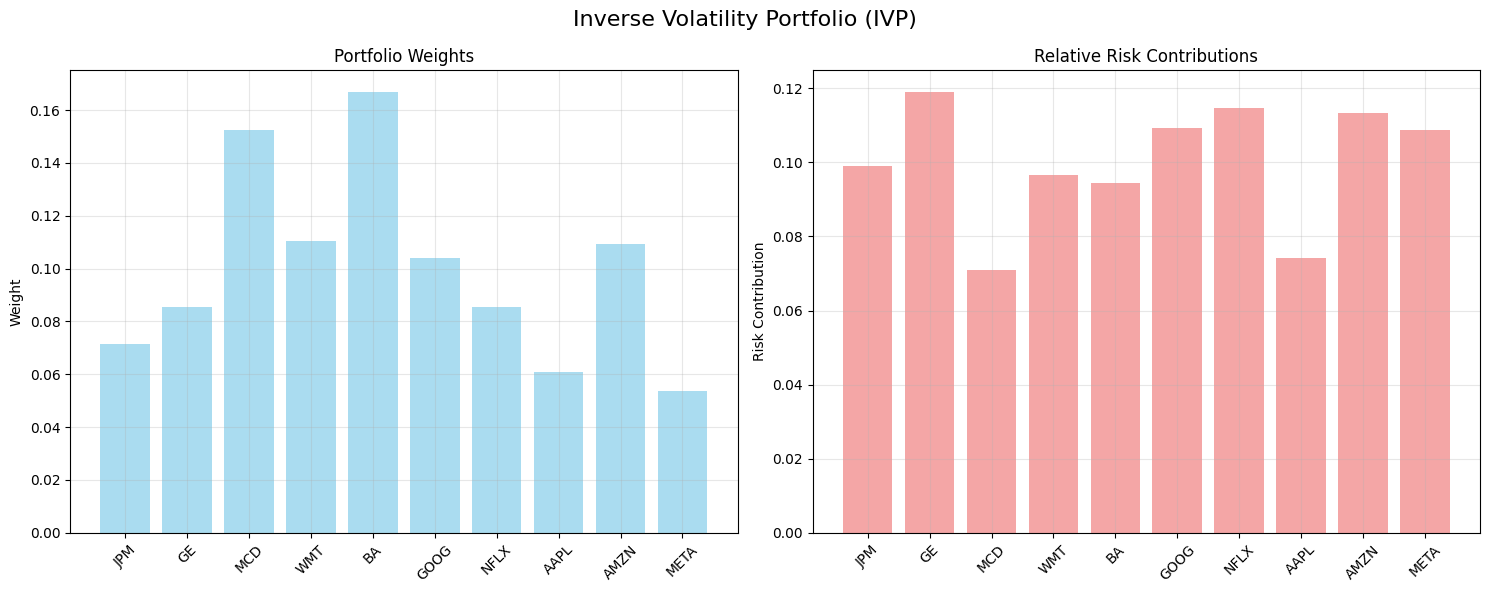


Portfolio volatility (weekly): 0.0545
Portfolio volatility (annualized): 0.3930

Relative risk contributions:
         RRC
JPM   0.0965
GE    0.1189
MCD   0.0945
WMT   0.0710
BA    0.0990
GOOG  0.1093
NFLX  0.1087
AAPL  0.1133
AMZN  0.1146
META  0.0743


In [26]:
def inverse_volatility_portfolio(Sigma):
    """
    Calculate Inverse Volatility Portfolio weights
    """
    vol = np.sqrt(np.diag(Sigma))
    weights = 1 / vol
    weights = weights / np.sum(weights)
    return weights

# Calculate IVP weights
w_IVP = inverse_volatility_portfolio(Sigma)

print("Inverse Volatility Portfolio (IVP) weights:")
ivp_df = pd.DataFrame({'Weight': w_IVP}, index=stock_list)
print(ivp_df.round(4))

# Plot portfolio weights and risk contributions
plot_risk_contributions(w_IVP, Sigma, stock_list, 'Inverse Volatility Portfolio (IVP)')

# Calculate portfolio metrics
risk_data = portfolio_risk_contribution(w_IVP, Sigma)
print(f"\nPortfolio volatility (weekly): {risk_data['portfolio_volatility']:.4f}")
print(f"Portfolio volatility (annualized): {risk_data['portfolio_volatility'] * np.sqrt(52):.4f}")

print("\nRelative risk contributions:")
rrc_df = pd.DataFrame({'RRC': risk_data['relative_risk_contribution']}, index=stock_list)
print(rrc_df.round(4))

## B. Risk Parity Portfolio (RPP) Variants

### B1. Naive Risk Budgeting Portfolio

Naive Risk Budgeting Portfolio weights:
(This equals IVP since it uses diagonal covariance)
      Weight
JPM   0.0714
GE    0.0855
MCD   0.1526
WMT   0.1106
BA    0.1667
GOOG  0.1040
NFLX  0.0856
AAPL  0.0607
AMZN  0.1093
META  0.0536

Verification - 1/vol normalized:
      Weight
JPM   0.0714
GE    0.0855
MCD   0.1526
WMT   0.1106
BA    0.1667
GOOG  0.1040
NFLX  0.0856
AAPL  0.0607
AMZN  0.1093
META  0.0536


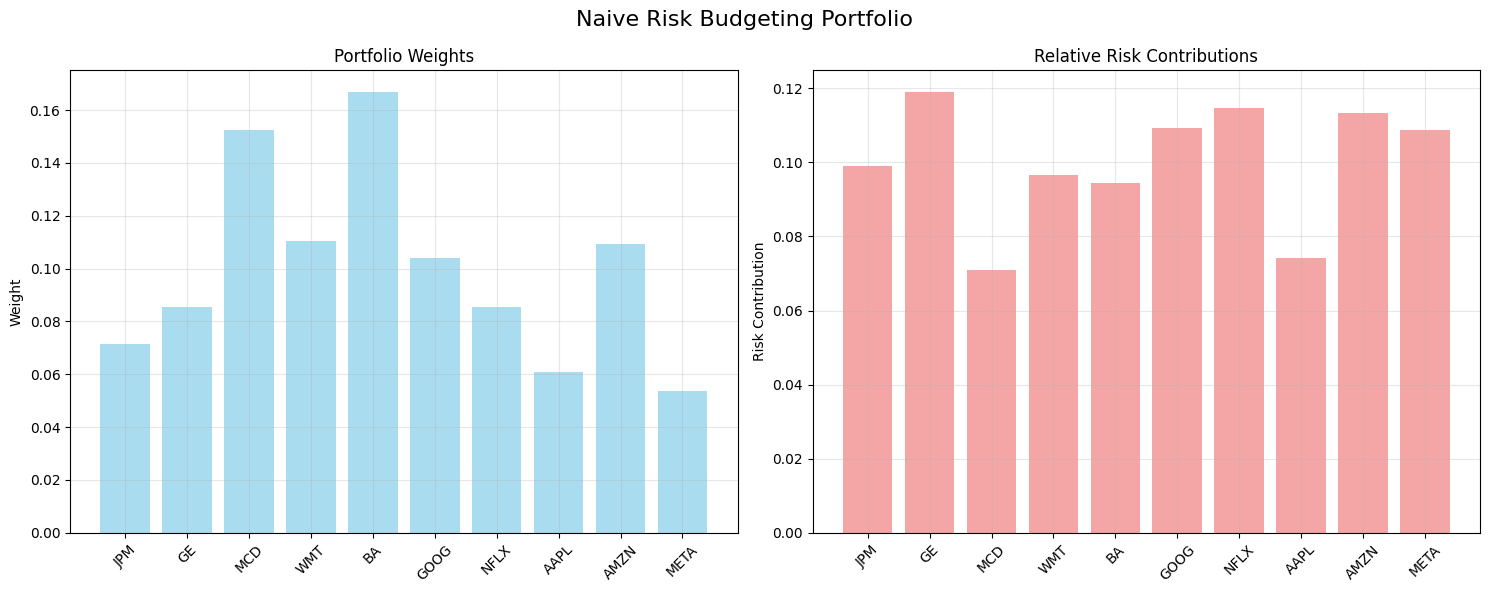

{'portfolio_volatility': np.float64(0.05449992681186786),
 'marginal_contribution': Ticker
 BA      0.075567
 GE      0.075749
 WMT     0.025351
 JPM     0.047572
 MCD     0.030875
 GOOG    0.057270
 AMZN    0.072960
 META    0.066664
 AAPL    0.056525
 NFLX    0.110479
 dtype: float64,
 'risk_contribution': Ticker
 BA      0.005395
 GE      0.006479
 WMT     0.003868
 JPM     0.005259
 MCD     0.005148
 GOOG    0.005956
 AMZN    0.006247
 META    0.004049
 AAPL    0.006175
 NFLX    0.005923
 dtype: float64,
 'relative_risk_contribution': Ticker
 BA      0.098998
 GE      0.118886
 WMT     0.070964
 JPM     0.096503
 MCD     0.094455
 GOOG    0.109280
 AMZN    0.114632
 META    0.074289
 AAPL    0.113311
 NFLX    0.108681
 dtype: float64}

In [27]:
# B1. Naive Risk Budgeting Portfolio (using diagonal covariance matrix)
def naive_risk_parity_portfolio(Sigma):
    """
    Calculate Risk Parity Portfolio using diagonal covariance matrix (naive approach)
    This is equivalent to the IVP when using diagonal covariance
    """
    vol = np.sqrt(np.diag(Sigma))
    weights = 1 / vol
    weights = weights / np.sum(weights)
    return weights

# Calculate naive RPP weights
w_RPP_naive = naive_risk_parity_portfolio(Sigma)

print("Naive Risk Budgeting Portfolio weights:")
print("(This equals IVP since it uses diagonal covariance)")
naive_rpp_df = pd.DataFrame({'Weight': w_RPP_naive}, index=stock_list)
print(naive_rpp_df.round(4))

# Verify it equals 1/vol normalized
vol_weights = (1/vol) / np.sum(1/vol)
print("\nVerification - 1/vol normalized:")
print(pd.DataFrame({'Weight': vol_weights}, index=stock_list).round(4))

# Plot
plot_risk_contributions(w_RPP_naive, Sigma, stock_list, 'Naive Risk Budgeting Portfolio')

### B2. Vanilla Risk Parity Portfolio

Vanilla Risk Parity Portfolio weights:
      Weight
JPM   0.1121
GE    0.0709
MCD   0.1688
WMT   0.1920
BA    0.0703
GOOG  0.0939
NFLX  0.0492
AAPL  0.0944
AMZN  0.0739
META  0.0744

Portfolio volatility (weekly): 0.0527
Portfolio volatility (annualized): 0.3801

Relative Risk Contributions (should be approximately equal):
      RRC
JPM   0.1
GE    0.1
MCD   0.1
WMT   0.1
BA    0.1
GOOG  0.1
NFLX  0.1
AAPL  0.1
AMZN  0.1
META  0.1
Sum of RRC: 1.0000

Marginal Risk Contributions:
         MRC
JPM   0.0470
GE    0.0743
MCD   0.0312
WMT   0.0274
BA    0.0750
GOOG  0.0561
NFLX  0.1071
AAPL  0.0558
AMZN  0.0713
META  0.0709


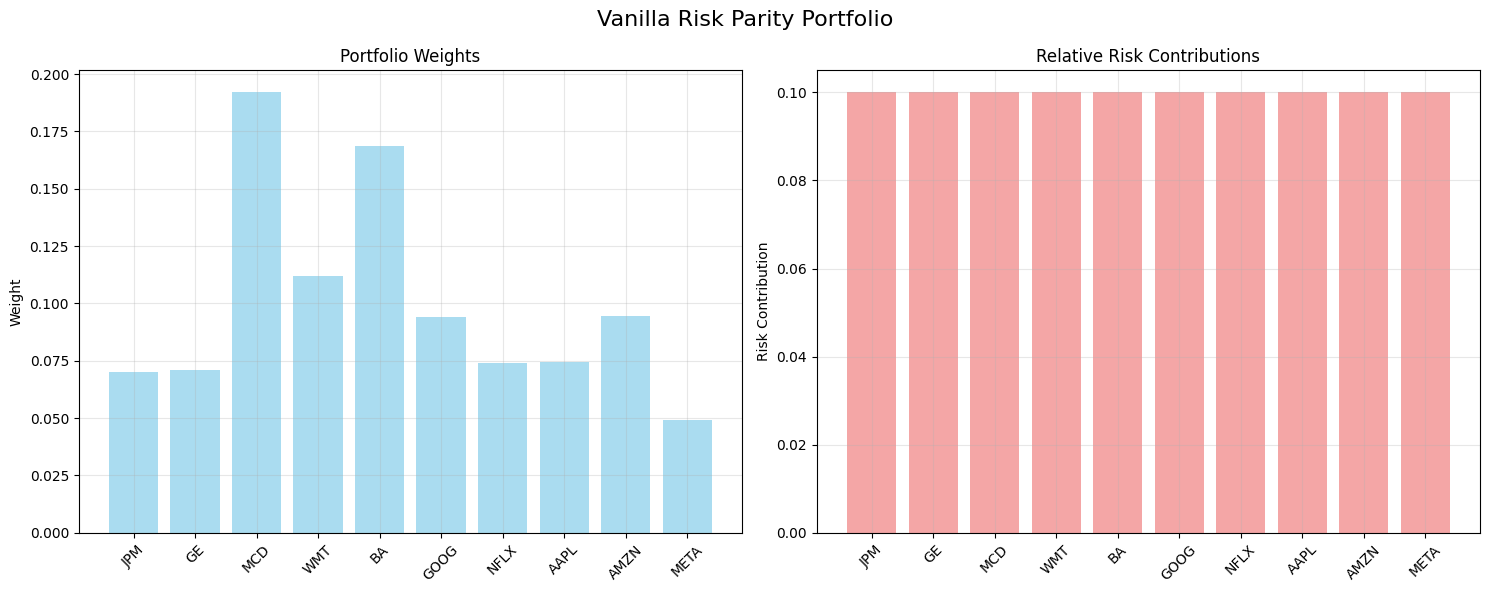

{'portfolio_volatility': np.float64(0.052710092533843976),
 'marginal_contribution': Ticker
 BA      0.074957
 GE      0.074316
 WMT     0.027450
 JPM     0.047025
 MCD     0.031230
 GOOG    0.056114
 AMZN    0.071341
 META    0.070867
 AAPL    0.055813
 NFLX    0.107082
 dtype: float64,
 'risk_contribution': Ticker
 BA      0.005271
 GE      0.005271
 WMT     0.005271
 JPM     0.005271
 MCD     0.005271
 GOOG    0.005271
 AMZN    0.005271
 META    0.005271
 AAPL    0.005271
 NFLX    0.005271
 dtype: float64,
 'relative_risk_contribution': Ticker
 BA      0.1
 GE      0.1
 WMT     0.1
 JPM     0.1
 MCD     0.1
 GOOG    0.1
 AMZN    0.1
 META    0.1
 AAPL    0.1
 NFLX    0.1
 dtype: float64}

In [28]:
def risk_parity_portfolio(Sigma, b=None, max_iter=1000, tol=1e-8):
    """
    Calculate Risk Parity Portfolio using iterative algorithm
    
    Parameters:
    - Sigma: covariance matrix
    - b: risk budgets (default: equal risk budgets)
    - max_iter: maximum iterations
    - tol: convergence tolerance
    """
    n = Sigma.shape[0]
    if b is None:
        b = np.ones(n) / n  # Equal risk budgets
    else:
        b = np.array(b) / np.sum(b)  # Normalize to sum to 1
    
    # Initial weights (equal weights)
    w = np.ones(n) / n
    
    for iteration in range(max_iter):
        # Calculate marginal risk contributions
        portfolio_vol = np.sqrt(w.T @ Sigma @ w)
        marginal_contrib = (Sigma @ w) / portfolio_vol
        
        # Update weights
        w_new = (b / marginal_contrib) / np.sum(b / marginal_contrib)
        
        # Check convergence
        if np.max(np.abs(w_new - w)) < tol:
            break
            
        w = w_new
    
    return w

# Calculate vanilla Risk Parity Portfolio
w_RPP = risk_parity_portfolio(Sigma)

print("Vanilla Risk Parity Portfolio weights:")
rpp_df = pd.DataFrame({'Weight': w_RPP}, index=stock_list)
print(rpp_df.round(4))

# Calculate and display risk contributions
risk_data = portfolio_risk_contribution(w_RPP, Sigma)

print(f"\nPortfolio volatility (weekly): {risk_data['portfolio_volatility']:.4f}")
print(f"Portfolio volatility (annualized): {risk_data['portfolio_volatility'] * np.sqrt(52):.4f}")

print("\nRelative Risk Contributions (should be approximately equal):")
rrc_df = pd.DataFrame({'RRC': risk_data['relative_risk_contribution']}, index=stock_list)
print(rrc_df.round(4))
print(f"Sum of RRC: {np.sum(risk_data['relative_risk_contribution']):.4f}")

print("\nMarginal Risk Contributions:")
mrc_df = pd.DataFrame({'MRC': risk_data['marginal_contribution']}, index=stock_list)
print(mrc_df.round(4))

# Plot
plot_risk_contributions(w_RPP, Sigma, stock_list, 'Vanilla Risk Parity Portfolio')

### B3. Risk Based Portfolio with Custom Risk Budgets

In [ ]:
# B3. Risk Based Portfolio with Custom Risk Budgets
# Example: Give GOOG twice the risk budget of other stocks
custom_budgets = np.array([2, 1, 1, 1, 1])  # GOOG gets double risk budget
w_RBP = risk_parity_portfolio(Sigma, b=custom_budgets)

print("Risk Based Portfolio (Custom Budgets) weights:")
print("Risk budgets: GOOG=2, others=1")
rbp_df = pd.DataFrame({'Weight': w_RBP}, index=stock_list)
print(rbp_df.round(4))

# Calculate and display risk contributions
risk_data_rbp = portfolio_risk_contribution(w_RBP, Sigma)

print("\nRelative Risk Contributions:")
rrc_rbp_df = pd.DataFrame({'RRC': risk_data_rbp['relative_risk_contribution']}, index=stock_list)
print(rrc_rbp_df.round(4))

print(f"\nExpected risk budget ratios (GOOG should be ~2x others):")
expected_budgets = custom_budgets / np.sum(custom_budgets)
actual_vs_expected = pd.DataFrame({
    'Expected': expected_budgets,
    'Actual': risk_data_rbp['relative_risk_contribution']
}, index=stock_list)
print(actual_vs_expected.round(4))

# Plot
plot_risk_contributions(w_RBP, Sigma, stock_list, 'Risk Based Portfolio (Custom Budgets)')

ValueError: operands could not be broadcast together with shapes (5,) (10,) 

### B4. RPP with Expected Return Term

Running parameter sweep for RPP with expected return term...


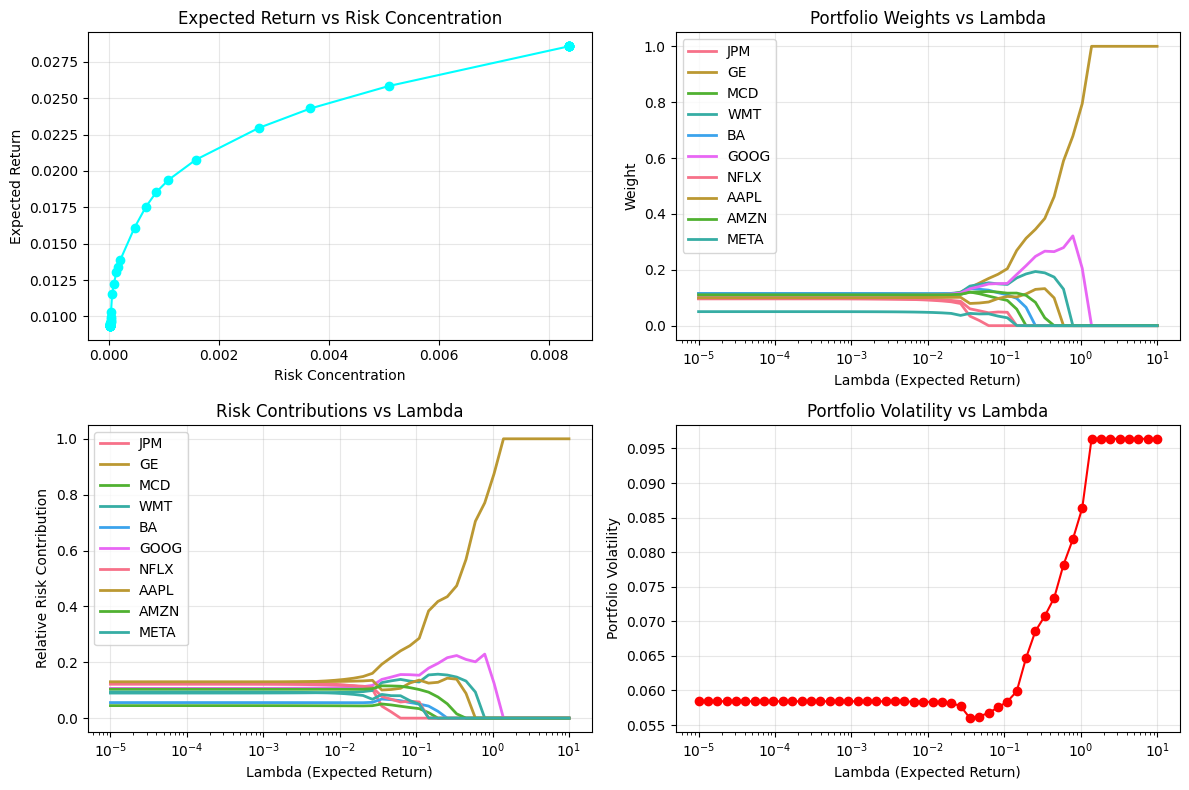


Results for lambda = 1.68e-04:
Weights:
      Weight
JPM   0.0971
GE    0.0975
MCD   0.1148
WMT   0.1111
BA    0.1152
GOOG  0.1077
NFLX  0.0958
AAPL  0.1000
AMZN  0.1106
META  0.0501
Expected return: 0.009368
Portfolio volatility: 0.058433

Results for lambda = 4.71e-02:
Weights:
      Weight
JPM   0.0185
GE    0.1524
MCD   0.1142
WMT   0.1475
BA    0.1304
GOOG  0.1400
NFLX  0.0533
AAPL  0.0811
AMZN  0.1208
META  0.0420
Expected return: 0.012252
Portfolio volatility: 0.056234


In [36]:
def risk_parity_with_return(Sigma, mu, lmd_mu=0.01, b=None, max_iter=1000, tol=1e-8):
    """
    Calculate Risk Parity Portfolio with expected return term
    Objective: minimize risk concentration + lambda * (-expected return)
    """
    n = Sigma.shape[0]
    if b is None:
        b = np.ones(n) / n
    else:
        b = np.array(b) / np.sum(b)
    
    # Use scipy.optimize for this more complex optimization
    from scipy.optimize import minimize
    
    def objective(w):
        # Portfolio volatility
        port_vol = np.sqrt(w.T @ Sigma @ w)
        
        # Risk contributions
        marginal_contrib = (Sigma @ w) / port_vol
        risk_contrib = w * marginal_contrib
        
        # Risk concentration (sum of squared deviations from target)
        risk_concentration = np.sum((risk_contrib - b * port_vol) ** 2)
        
        # Expected return penalty
        expected_return = w.T @ mu
        
        return risk_concentration - lmd_mu * expected_return
    
    # Constraints
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n)]
    
    # Initial guess
    w0 = np.ones(n) / n
    
    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        print("Optimization failed")
        return w0

# Sweep over different lambda values for expected return term
lambda_values = np.logspace(-5, 1, 50)  # from 10^-5 to 10^1
results_return = []

print("Running parameter sweep for RPP with expected return term...")

for lmd in lambda_values:
    w = risk_parity_with_return(Sigma, mu, lmd_mu=lmd)
    
    # Calculate portfolio metrics
    expected_ret = w.T @ mu
    portfolio_vol = np.sqrt(w.T @ Sigma @ w)
    risk_data = portfolio_risk_contribution(w, Sigma)
    
    # Risk concentration measure
    risk_contrib = risk_data['risk_contribution']
    target_contrib = portfolio_vol / len(stock_list)  # Equal contributions
    risk_concentration = np.sum((risk_contrib - target_contrib) ** 2)
    
    results_return.append({
        'lambda': lmd,
        'expected_return': expected_ret,
        'portfolio_vol': portfolio_vol,
        'risk_concentration': risk_concentration,
        'weights': w.copy()
    })

# Convert to DataFrame for easier plotting
results_df = pd.DataFrame(results_return)

# Plot efficient frontier-like plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(results_df['risk_concentration'], results_df['expected_return'], 'o-', color='cyan')
plt.xlabel('Risk Concentration')
plt.ylabel('Expected Return')
plt.title('Expected Return vs Risk Concentration')
plt.grid(True, alpha=0.3)

# Plot weights evolution
plt.subplot(2, 2, 2)
weights_matrix = np.array([r['weights'] for r in results_return])
for i, stock in enumerate(stock_list):
    plt.plot(lambda_values, weights_matrix[:, i], label=stock, linewidth=2)
plt.xlabel('Lambda (Expected Return)')
plt.ylabel('Weight')
plt.title('Portfolio Weights vs Lambda')
plt.legend()
plt.xscale('log')
plt.grid(True, alpha=0.3)

# Plot relative risk contributions
plt.subplot(2, 2, 3)
rrc_matrix = np.array([portfolio_risk_contribution(r['weights'], Sigma)['relative_risk_contribution'] 
                       for r in results_return])
for i, stock in enumerate(stock_list):
    plt.plot(lambda_values, rrc_matrix[:, i], label=stock, linewidth=2)
plt.xlabel('Lambda (Expected Return)')
plt.ylabel('Relative Risk Contribution')
plt.title('Risk Contributions vs Lambda')
plt.legend()
plt.xscale('log')
plt.grid(True, alpha=0.3)

# Plot portfolio volatility
plt.subplot(2, 2, 4)
plt.plot(lambda_values, results_df['portfolio_vol'], 'o-', color='red')
plt.xlabel('Lambda (Expected Return)')
plt.ylabel('Portfolio Volatility')
plt.title('Portfolio Volatility vs Lambda')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show some specific examples
print(f"\nResults for lambda = {lambda_values[10]:.2e}:")
idx = 10
w_example = results_return[idx]['weights']
print("Weights:")
print(pd.DataFrame({'Weight': w_example}, index=stock_list).round(4))
print(f"Expected return: {results_return[idx]['expected_return']:.6f}")
print(f"Portfolio volatility: {results_return[idx]['portfolio_vol']:.6f}")

print(f"\nResults for lambda = {lambda_values[30]:.2e}:")
idx = 30
w_example = results_return[idx]['weights']
print("Weights:")
print(pd.DataFrame({'Weight': w_example}, index=stock_list).round(4))
print(f"Expected return: {results_return[idx]['expected_return']:.6f}")
print(f"Portfolio volatility: {results_return[idx]['portfolio_vol']:.6f}")

### B5. RPP with Variance Term

Running parameter sweep for RPP with variance term...


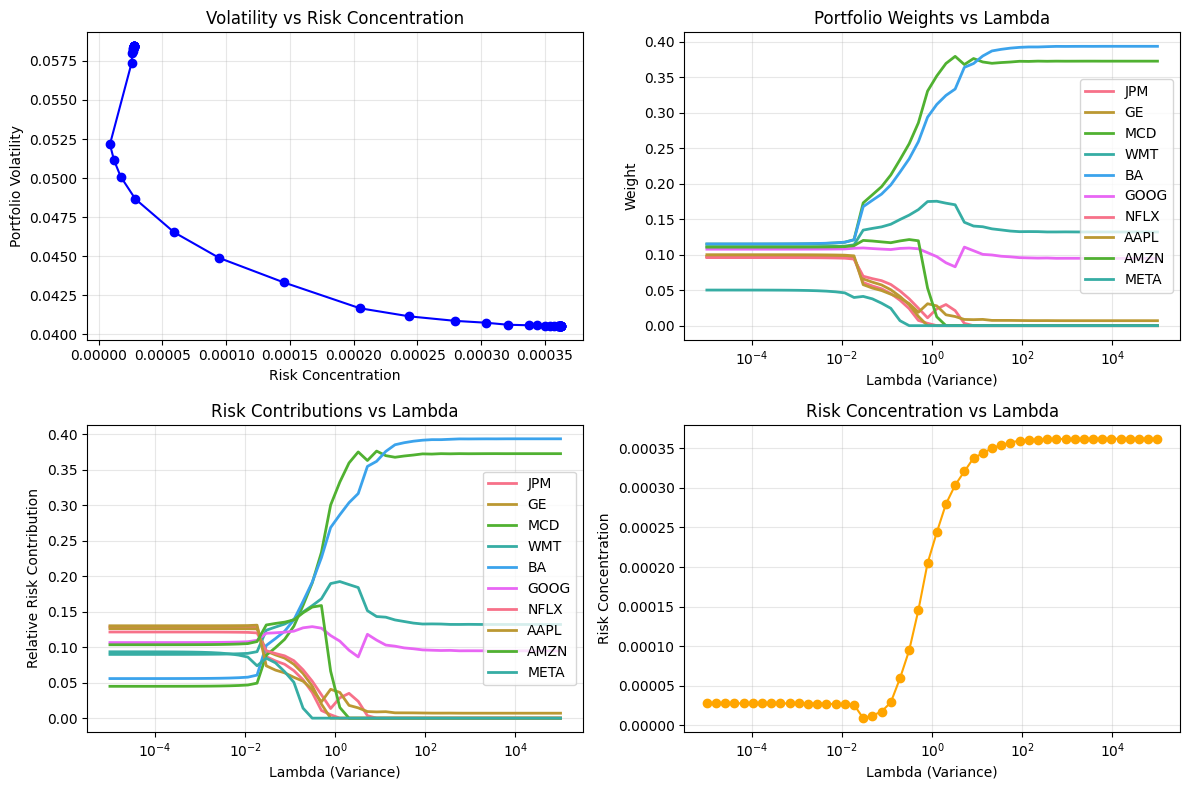


Results for lambda = 1.10e-03 (low variance penalty):
Weights:
      Weight
JPM   0.0972
GE    0.0973
MCD   0.1151
WMT   0.1111
BA    0.1154
GOOG  0.1077
NFLX  0.0958
AAPL  0.0999
AMZN  0.1107
META  0.0498
Portfolio volatility: 0.058392
Risk concentration: 0.000027

Results for lambda = 1.46e+03 (high variance penalty):
Weights:
      Weight
JPM   0.0000
GE    0.0000
MCD   0.3726
WMT   0.1320
BA    0.3935
GOOG  0.0949
NFLX  0.0000
AAPL  0.0070
AMZN  0.0000
META  0.0000
Portfolio volatility: 0.040555
Risk concentration: 0.000362


In [37]:
def risk_parity_with_variance(Sigma, lmd_var=0.01, b=None, max_iter=1000, tol=1e-8):
    """
    Calculate Risk Parity Portfolio with variance term
    Objective: minimize risk concentration + lambda * portfolio variance
    """
    n = Sigma.shape[0]
    if b is None:
        b = np.ones(n) / n
    else:
        b = np.array(b) / np.sum(b)
    
    from scipy.optimize import minimize
    
    def objective(w):
        # Portfolio variance
        port_var = w.T @ Sigma @ w
        port_vol = np.sqrt(port_var)
        
        # Risk contributions
        marginal_contrib = (Sigma @ w) / port_vol
        risk_contrib = w * marginal_contrib
        
        # Risk concentration (sum of squared deviations from target)
        risk_concentration = np.sum((risk_contrib - b * port_vol) ** 2)
        
        return risk_concentration + lmd_var * port_var
    
    # Constraints
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n)]
    
    # Initial guess
    w0 = np.ones(n) / n
    
    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        print("Optimization failed")
        return w0

# Sweep over different lambda values for variance term
lambda_var_values = np.logspace(-5, 5, 50)  # from 10^-5 to 10^5
results_variance = []

print("Running parameter sweep for RPP with variance term...")

for lmd in lambda_var_values:
    w = risk_parity_with_variance(Sigma, lmd_var=lmd)
    
    # Calculate portfolio metrics
    portfolio_var = w.T @ Sigma @ w
    portfolio_vol = np.sqrt(portfolio_var)
    risk_data = portfolio_risk_contribution(w, Sigma)
    
    # Risk concentration measure
    risk_contrib = risk_data['risk_contribution']
    target_contrib = portfolio_vol / len(stock_list)  # Equal contributions
    risk_concentration = np.sum((risk_contrib - target_contrib) ** 2)
    
    results_variance.append({
        'lambda': lmd,
        'portfolio_var': portfolio_var,
        'portfolio_vol': portfolio_vol,
        'risk_concentration': risk_concentration,
        'weights': w.copy()
    })

# Convert to DataFrame for easier plotting
results_var_df = pd.DataFrame(results_variance)

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(results_var_df['risk_concentration'], results_var_df['portfolio_vol'], 'o-', color='blue')
plt.xlabel('Risk Concentration')
plt.ylabel('Portfolio Volatility')
plt.title('Volatility vs Risk Concentration')
plt.grid(True, alpha=0.3)

# Plot weights evolution
plt.subplot(2, 2, 2)
weights_var_matrix = np.array([r['weights'] for r in results_variance])
for i, stock in enumerate(stock_list):
    plt.plot(lambda_var_values, weights_var_matrix[:, i], label=stock, linewidth=2)
plt.xlabel('Lambda (Variance)')
plt.ylabel('Weight')
plt.title('Portfolio Weights vs Lambda')
plt.legend()
plt.xscale('log')
plt.grid(True, alpha=0.3)

# Plot relative risk contributions
plt.subplot(2, 2, 3)
rrc_var_matrix = np.array([portfolio_risk_contribution(r['weights'], Sigma)['relative_risk_contribution'] 
                           for r in results_variance])
for i, stock in enumerate(stock_list):
    plt.plot(lambda_var_values, rrc_var_matrix[:, i], label=stock, linewidth=2)
plt.xlabel('Lambda (Variance)')
plt.ylabel('Relative Risk Contribution')
plt.title('Risk Contributions vs Lambda')
plt.legend()
plt.xscale('log')
plt.grid(True, alpha=0.3)

# Plot risk concentration
plt.subplot(2, 2, 4)
plt.plot(lambda_var_values, results_var_df['risk_concentration'], 'o-', color='orange')
plt.xlabel('Lambda (Variance)')
plt.ylabel('Risk Concentration')
plt.title('Risk Concentration vs Lambda')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show some specific examples
print(f"\nResults for lambda = {lambda_var_values[10]:.2e} (low variance penalty):")
idx = 10
w_example = results_variance[idx]['weights']
print("Weights:")
print(pd.DataFrame({'Weight': w_example}, index=stock_list).round(4))
print(f"Portfolio volatility: {results_variance[idx]['portfolio_vol']:.6f}")
print(f"Risk concentration: {results_variance[idx]['risk_concentration']:.6f}")

print(f"\nResults for lambda = {lambda_var_values[40]:.2e} (high variance penalty):")
idx = 40
w_example = results_variance[idx]['weights']
print("Weights:")
print(pd.DataFrame({'Weight': w_example}, index=stock_list).round(4))
print(f"Portfolio volatility: {results_variance[idx]['portfolio_vol']:.6f}")
print(f"Risk concentration: {results_variance[idx]['risk_concentration']:.6f}")

### B6. RPP with Linear Constraints

Constraint interpretation:
Constraint 1: w_GOOG + w_NFLX >= 50%
Constraint 2: w_NFLX >= w_AAPL + 10%

RPP with Linear Constraints weights:
     Weight
JPM  0.1211
GE   0.3789
MCD  0.2789
WMT  0.0000
BA   0.2211

Constraint verification:
w_GOOG + w_NFLX = 0.5000 (should be >= 0.50)
w_NFLX - w_AAPL = 0.1000 (should be >= 0.10)
Sum of weights = 1.0000 (should be 1.00)

Constraint values (should be <= b_ineq):
Constraint 1: -0.5000 <= -0.5000 ✓
Constraint 2: -0.1000 <= -0.1000 ✓


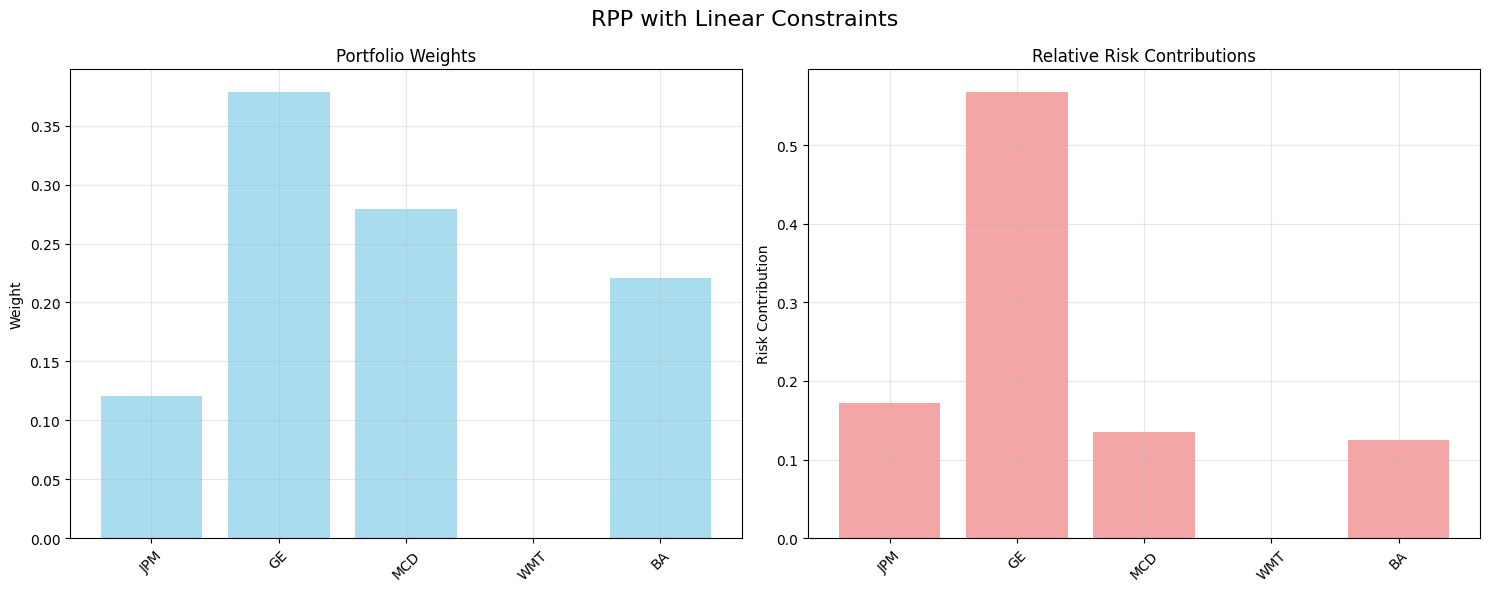

{'portfolio_volatility': np.float64(0.05785174914119207),
 'marginal_contribution': Ticker
 BA     0.081990
 GE     0.086697
 WMT    0.028065
 JPM    0.050344
 MCD    0.032772
 dtype: float64,
 'risk_contribution': Ticker
 BA     9.926212e-03
 GE     3.285236e-02
 WMT    7.828357e-03
 JPM    2.638323e-23
 MCD    7.244819e-03
 dtype: float64,
 'relative_risk_contribution': Ticker
 BA     1.715802e-01
 GE     5.678715e-01
 WMT    1.353176e-01
 JPM    4.560490e-22
 MCD    1.252308e-01
 dtype: float64}

In [ ]:
def risk_parity_with_constraints(Sigma, A_eq=None, b_eq=None, A_ineq=None, b_ineq=None, 
                                b_risk=None, max_iter=1000, tol=1e-8):
    """
    Calculate Risk Parity Portfolio with linear constraints using cvxpy
    
    Parameters:
    - Sigma: covariance matrix
    - A_eq, b_eq: equality constraints A_eq @ w = b_eq
    - A_ineq, b_ineq: inequality constraints A_ineq @ w <= b_ineq
    - b_risk: risk budgets
    """
    n = Sigma.shape[0]
    if b_risk is None:
        b_risk = np.ones(n) / n
    else:
        b_risk = np.array(b_risk) / np.sum(b_risk)
    
    # Use cvxpy for constrained optimization
    w = cp.Variable(n, nonneg=True)
    
    # Portfolio variance
    port_var = cp.quad_form(w, Sigma)
    port_vol = cp.sqrt(port_var)
    
    # For risk parity with constraints, we'll minimize portfolio variance
    # subject to risk budget constraints and linear constraints
    objective = cp.Minimize(port_var)
    
    # Base constraints
    constraints = [cp.sum(w) == 1]  # weights sum to 1
    
    # Add equality constraints if provided
    if A_eq is not None and b_eq is not None:
        constraints.append(A_eq @ w == b_eq)
    
    # Add inequality constraints if provided  
    if A_ineq is not None and b_ineq is not None:
        constraints.append(A_ineq @ w <= b_ineq)
    
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    if prob.status == cp.OPTIMAL:
        return w.value
    else:
        print(f"Optimization status: {prob.status}")
        return np.ones(n) / n

# Example constraints from the R code:
# w1 + w2 >= 50%  -->  -w1 - w2 <= -0.5
# w2 >= w3 + 10%  -->  -w2 + w3 <= -0.1
# These translate to: A_ineq @ w <= b_ineq

# Define constraint matrices
n_assets = len(stock_list)
A_ineq = np.array([
    [-1, -1, 0, 0, 0],  # -w1 - w2 <= -0.5 (w1 + w2 >= 0.5)
    [0, -1, 1, 0, 0]    # -w2 + w3 <= -0.1 (w2 >= w3 + 0.1)
])
b_ineq = np.array([-0.50, -0.10])

print("Constraint interpretation:")
print("Constraint 1: w_GOOG + w_NFLX >= 50%")
print("Constraint 2: w_NFLX >= w_AAPL + 10%")

# Calculate constrained RPP
w_RPP_constrained = risk_parity_with_constraints(Sigma, A_ineq=A_ineq, b_ineq=b_ineq)

print(f"\nRPP with Linear Constraints weights:")
constrained_df = pd.DataFrame({'Weight': w_RPP_constrained}, index=stock_list)
print(constrained_df.round(4))

# Verify constraints
print(f"\nConstraint verification:")
print(f"w_GOOG + w_NFLX = {w_RPP_constrained[0] + w_RPP_constrained[1]:.4f} (should be >= 0.50)")
print(f"w_NFLX - w_AAPL = {w_RPP_constrained[1] - w_RPP_constrained[2]:.4f} (should be >= 0.10)")
print(f"Sum of weights = {np.sum(w_RPP_constrained):.4f} (should be 1.00)")

# Check inequality constraints
constraint_values = A_ineq @ w_RPP_constrained
print(f"\nConstraint values (should be <= b_ineq):")
for i, (val, bound) in enumerate(zip(constraint_values, b_ineq)):
    print(f"Constraint {i+1}: {val:.4f} <= {bound:.4f} ✓" if val <= bound + 1e-6 else f"Constraint {i+1}: {val:.4f} <= {bound:.4f} ✗")

# Plot
plot_risk_contributions(w_RPP_constrained, Sigma, stock_list, 
                       'RPP with Linear Constraints')

## C. Most Diversified Portfolio (MDP)

### C1. Maximum Sharpe Ratio Portfolio (MSRP)

Maximum Sharpe Ratio Portfolio (MSRP) weights:
     Weight
JPM  0.0000
GE   0.7565
MCD  0.0570
WMT  0.0000
BA   0.1866

Portfolio expected return (weekly): 0.023291
Portfolio expected return (annualized): 1.2111
Portfolio volatility (weekly): 0.077968
Portfolio volatility (annualized): 0.5622
Sharpe ratio: 0.2987


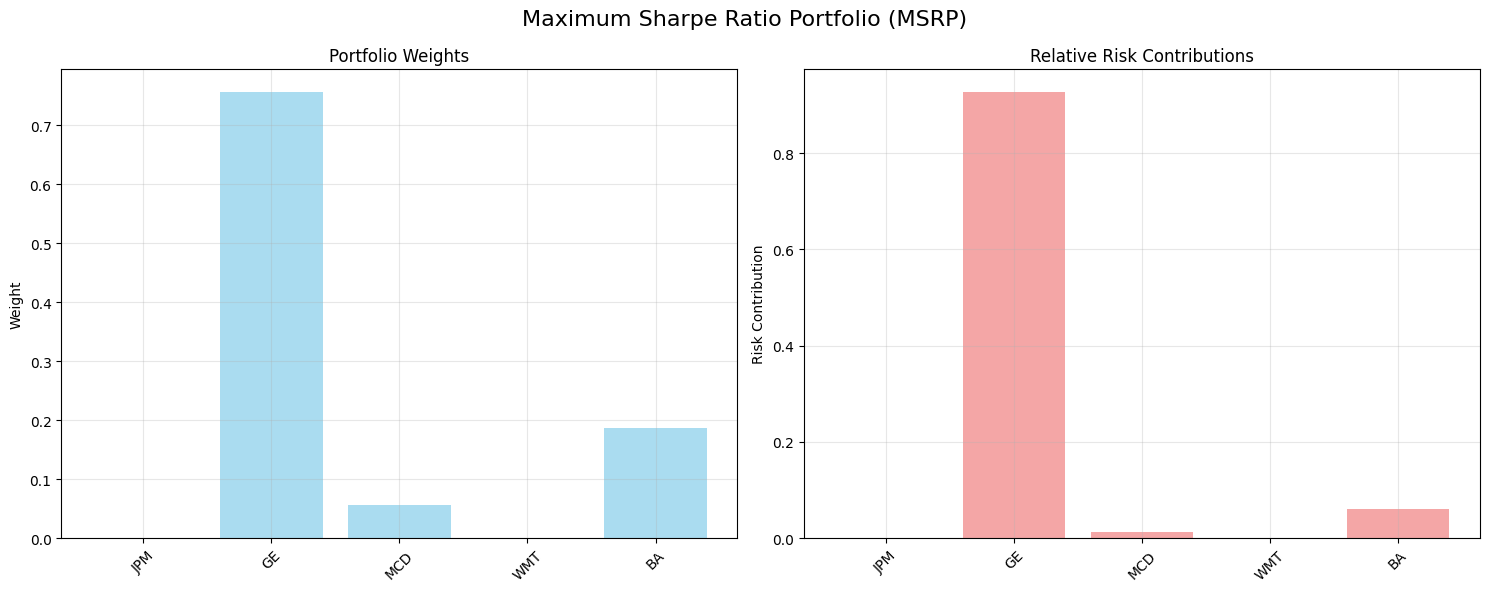

{'portfolio_volatility': np.float64(0.07796761090628693),
 'marginal_contribution': Ticker
 BA     0.065381
 GE     0.095624
 WMT    0.016865
 JPM    0.054686
 MCD    0.025023
 dtype: float64,
 'risk_contribution': Ticker
 BA     0.000000
 GE     0.072339
 WMT    0.000961
 JPM    0.000000
 MCD    0.004668
 dtype: float64,
 'relative_risk_contribution': Ticker
 BA     0.000000
 GE     0.927808
 WMT    0.012320
 JPM    0.000000
 MCD    0.059872
 dtype: float64}

In [ ]:
def maximum_sharpe_ratio_portfolio(mu, Sigma):
    """
    Calculate Maximum Sharpe Ratio Portfolio using the dual formulation
    Minimize w'Σw subject to μ'w = 1, w >= 0
    Then normalize: w_final = w / sum(w)

    Notes:
    - Convert pandas objects to numpy arrays to avoid shape/typing issues with cvxpy.
    - If the optimization is infeasible or fails, fall back to equal weights.
    """
    # Convert to numpy arrays (handles pandas Series/DataFrame inputs)
    mu_arr = np.asarray(mu).reshape(-1)
    Sigma_mat = np.asarray(Sigma)

    # Basic dimension checks
    if Sigma_mat.ndim != 2 or Sigma_mat.shape[0] != Sigma_mat.shape[1]:
        raise ValueError("Sigma must be a square (n x n) matrix.")
    if Sigma_mat.shape[0] != mu_arr.shape[0]:
        raise ValueError("Dimension mismatch between mu and Sigma.")

    n = mu_arr.shape[0]

    # Define the optimization variables
    w = cp.Variable(n, nonneg=True)

    # Objective: minimize portfolio variance (use numpy array for Sigma)
    objective = cp.Minimize(cp.quad_form(w, Sigma_mat))

    # Constraint: expected return requirement (use cp expressions)
    constraints = [cp.sum(cp.multiply(mu_arr, w)) == 1]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve()
    except Exception as e:
        print(f"MSRP optimization error: {e}")
        return np.ones(n) / n

    # Validate solution and normalize
    if prob.status == cp.OPTIMAL and w.value is not None:
        w_unnormalized = np.asarray(w.value).reshape(-1)
        s = np.sum(w_unnormalized)
        if s > 0:
            w_final = w_unnormalized / s
            return w_final
        else:
            # fallback
            return np.ones(n) / n
    else:
        print(f"MSRP optimization failed or infeasible: {prob.status}")
        return np.ones(n) / n

# Calculate MSRP weights
w_MSRP = maximum_sharpe_ratio_portfolio(mu, Sigma)

print("Maximum Sharpe Ratio Portfolio (MSRP) weights:")
msrp_df = pd.DataFrame({'Weight': w_MSRP}, index=stock_list)
print(msrp_df.round(4))

# Calculate portfolio metrics
portfolio_return = w_MSRP.T @ mu
portfolio_vol = np.sqrt(w_MSRP.T @ Sigma @ w_MSRP)
sharpe_ratio = portfolio_return / portfolio_vol

print(f"\nPortfolio expected return (weekly): {portfolio_return:.6f}")
print(f"Portfolio expected return (annualized): {portfolio_return * 52:.4f}")
print(f"Portfolio volatility (weekly): {portfolio_vol:.6f}")  
print(f"Portfolio volatility (annualized): {portfolio_vol * np.sqrt(52):.4f}")
print(f"Sharpe ratio: {sharpe_ratio:.4f}")

# Plot
plot_risk_contributions(w_MSRP, Sigma, stock_list, 'Maximum Sharpe Ratio Portfolio (MSRP)')

### C2. Most Diversified Portfolio

Most Diversified Portfolio (MDP) weights:
      Weight
JPM   0.0755
GE    0.0000
MCD   0.3363
WMT   0.1408
BA    0.1771
GOOG  0.0751
NFLX  0.0025
AAPL  0.1288
AMZN  0.0000
META  0.0638

Weighted average volatility: 0.079657
Portfolio volatility: 0.049207
Diversification ratio: 1.6188
(Higher diversification ratio indicates better diversification)


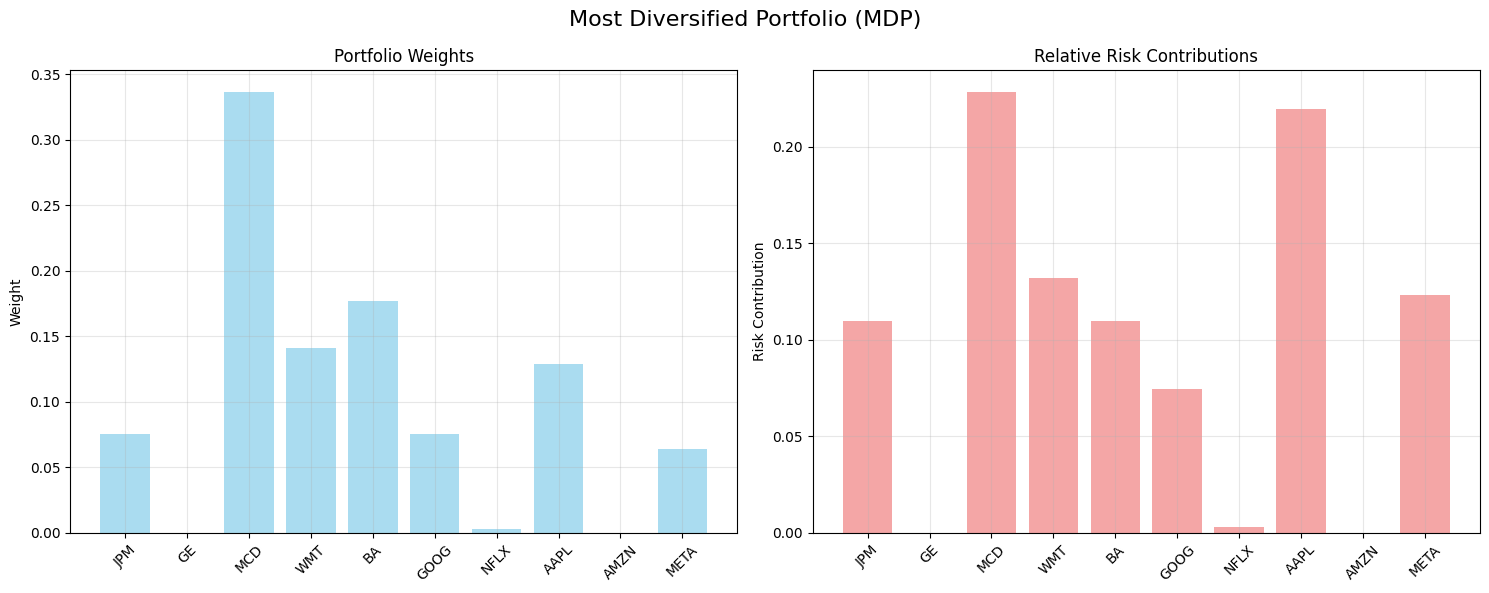

{'portfolio_volatility': np.float64(0.04920654490392393),
 'marginal_contribution': Ticker
 BA      0.071338
 GE      0.066072
 WMT     0.033387
 JPM     0.046070
 MCD     0.030549
 GOOG    0.048978
 AMZN    0.059483
 META    0.083866
 AAPL    0.046922
 NFLX    0.095004
 dtype: float64,
 'risk_contribution': Ticker
 BA      5.388632e-03
 GE      0.000000e+00
 WMT     1.122918e-02
 JPM     6.485358e-03
 MCD     5.411256e-03
 GOOG    3.678365e-03
 AMZN    1.498065e-04
 META    1.080185e-02
 AAPL    1.550239e-22
 NFLX    6.062093e-03
 dtype: float64,
 'relative_risk_contribution': Ticker
 BA      1.095105e-01
 GE      0.000000e+00
 WMT     2.282051e-01
 JPM     1.317987e-01
 MCD     1.099702e-01
 GOOG    7.475357e-02
 AMZN    3.044443e-03
 META    2.195206e-01
 AAPL    3.150473e-21
 NFLX    1.231969e-01
 dtype: float64}

In [31]:
# C2. Most Diversified Portfolio (MDP)
# MDP is equivalent to MSRP with μ replaced by individual asset volatilities
# o objetivo desta é maximizar a razão de diversificação DR = (w' * σ) / sqrt(w' * Σ * w)
# onde σ é o vetor de volatilidades individuais

def most_diversified_portfolio(Sigma):
    """
    Calculate Most Diversified Portfolio
    This is MSRP where expected returns are replaced by individual volatilities
    """
    vol = np.sqrt(np.diag(Sigma))  # Individual asset volatilities
    return maximum_sharpe_ratio_portfolio(vol, Sigma)

# Calculate MDP weights  
w_MDP = most_diversified_portfolio(Sigma)

print("Most Diversified Portfolio (MDP) weights:")
mdp_df = pd.DataFrame({'Weight': w_MDP}, index=stock_list)
print(mdp_df.round(4))

# Calculate diversification ratio
# DR = (w' * σ) / sqrt(w' * Σ * w)
# where σ is the vector of individual volatilities
individual_vols = np.sqrt(np.diag(Sigma))
weighted_avg_vol = w_MDP.T @ individual_vols
portfolio_vol_mdp = np.sqrt(w_MDP.T @ Sigma @ w_MDP)
diversification_ratio = weighted_avg_vol / portfolio_vol_mdp

print(f"\nWeighted average volatility: {weighted_avg_vol:.6f}")
print(f"Portfolio volatility: {portfolio_vol_mdp:.6f}")
print(f"Diversification ratio: {diversification_ratio:.4f}")
print("(Higher diversification ratio indicates better diversification)")

# Plot
plot_risk_contributions(w_MDP, Sigma, stock_list, 'Most Diversified Portfolio (MDP)')

## D. Maximum Decorrelation Portfolio (MDCP)

Global Minimum Variance Portfolio (GMVP) weights:
      Weight
JPM   0.0000
GE    0.0000
MCD   0.3726
WMT   0.1320
BA    0.3936
GOOG  0.0949
NFLX  0.0000
AAPL  0.0070
AMZN  0.0000
META  0.0000

Portfolio volatility (weekly): 0.040555
Portfolio volatility (annualized): 0.2924
Portfolio expected return (weekly): 0.008203
Portfolio expected return (annualized): 0.4265


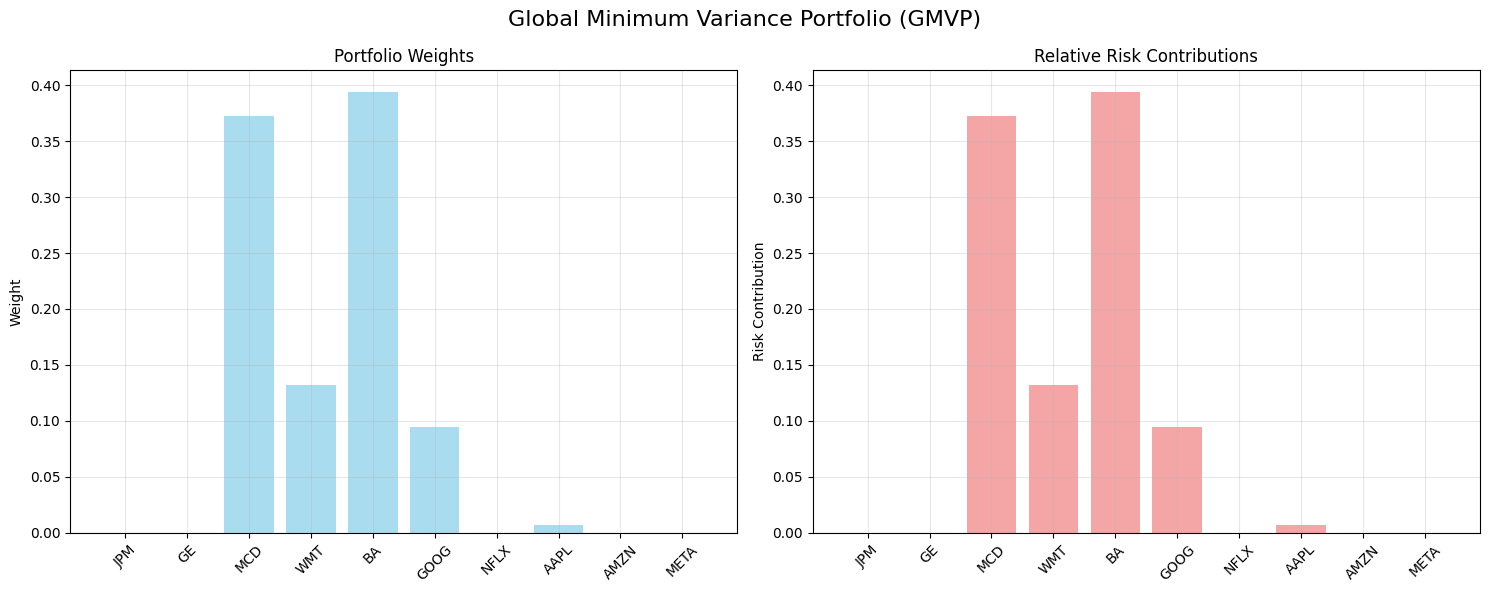

{'portfolio_volatility': np.float64(0.04055542603223977),
 'marginal_contribution': Ticker
 BA      0.057107
 GE      0.057184
 WMT     0.040555
 JPM     0.040555
 MCD     0.040555
 GOOG    0.040555
 AMZN    0.041282
 META    0.040555
 AAPL    0.048069
 NFLX    0.065627
 dtype: float64,
 'risk_contribution': Ticker
 BA      0.000000e+00
 GE      2.587353e-22
 WMT     1.511228e-02
 JPM     5.351915e-03
 MCD     1.596079e-02
 GOOG    3.846946e-03
 AMZN    6.052361e-23
 META    2.834945e-04
 AAPL    0.000000e+00
 NFLX    4.361191e-22
 dtype: float64,
 'relative_risk_contribution': Ticker
 BA      0.000000e+00
 GE      6.379796e-21
 WMT     3.726327e-01
 JPM     1.319654e-01
 MCD     3.935550e-01
 GOOG    9.485650e-02
 AMZN    1.492368e-21
 META    6.990297e-03
 AAPL    0.000000e+00
 NFLX    1.075366e-20
 dtype: float64}

In [30]:
def global_minimum_variance_portfolio(Sigma):
    """
    Calculate Global Minimum Variance Portfolio
    Minimize w'Σw subject to sum(w) = 1, w >= 0
    """
    n = Sigma.shape[0]
    
    # Define the optimization variables
    w = cp.Variable(n, nonneg=True)
    
    # Objective: minimize portfolio variance
    objective = cp.Minimize(cp.quad_form(w, Sigma))
    
    # Constraints: weights sum to 1
    constraints = [cp.sum(w) == 1]
    
    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()
    
    if prob.status == cp.OPTIMAL:
        return w.value
    else:
        print(f"GMVP optimization failed: {prob.status}")
        return np.ones(n) / n

# Calculate GMVP weights
w_GMVP = global_minimum_variance_portfolio(Sigma)

print("Global Minimum Variance Portfolio (GMVP) weights:")
gmvp_df = pd.DataFrame({'Weight': w_GMVP}, index=stock_list)
print(gmvp_df.round(4))

# Calculate portfolio metrics
portfolio_vol_gmvp = np.sqrt(w_GMVP.T @ Sigma @ w_GMVP)
portfolio_ret_gmvp = w_GMVP.T @ mu

print(f"\nPortfolio volatility (weekly): {portfolio_vol_gmvp:.6f}")
print(f"Portfolio volatility (annualized): {portfolio_vol_gmvp * np.sqrt(52):.4f}")
print(f"Portfolio expected return (weekly): {portfolio_ret_gmvp:.6f}")
print(f"Portfolio expected return (annualized): {portfolio_ret_gmvp * 52:.4f}")

# Plot
plot_risk_contributions(w_GMVP, Sigma, stock_list, 'Global Minimum Variance Portfolio (GMVP)')

## Portfolio Comparison

Maximum Decorrelation Portfolio (MDCP) weights:
      Weight
JPM   0.1095
GE    0.0000
MCD   0.2282
WMT   0.1318
BA    0.1100
GOOG  0.0748
NFLX  0.0030
AAPL  0.2195
AMZN  0.0000
META  0.1232

Portfolio volatility (weekly): 0.060569
Portfolio volatility (annualized): 0.4368
Portfolio expected return (weekly): 0.007080
Portfolio expected return (annualized): 0.3681

Average pairwise correlation in portfolio: 0.2616
(Lower correlation indicates better diversification)


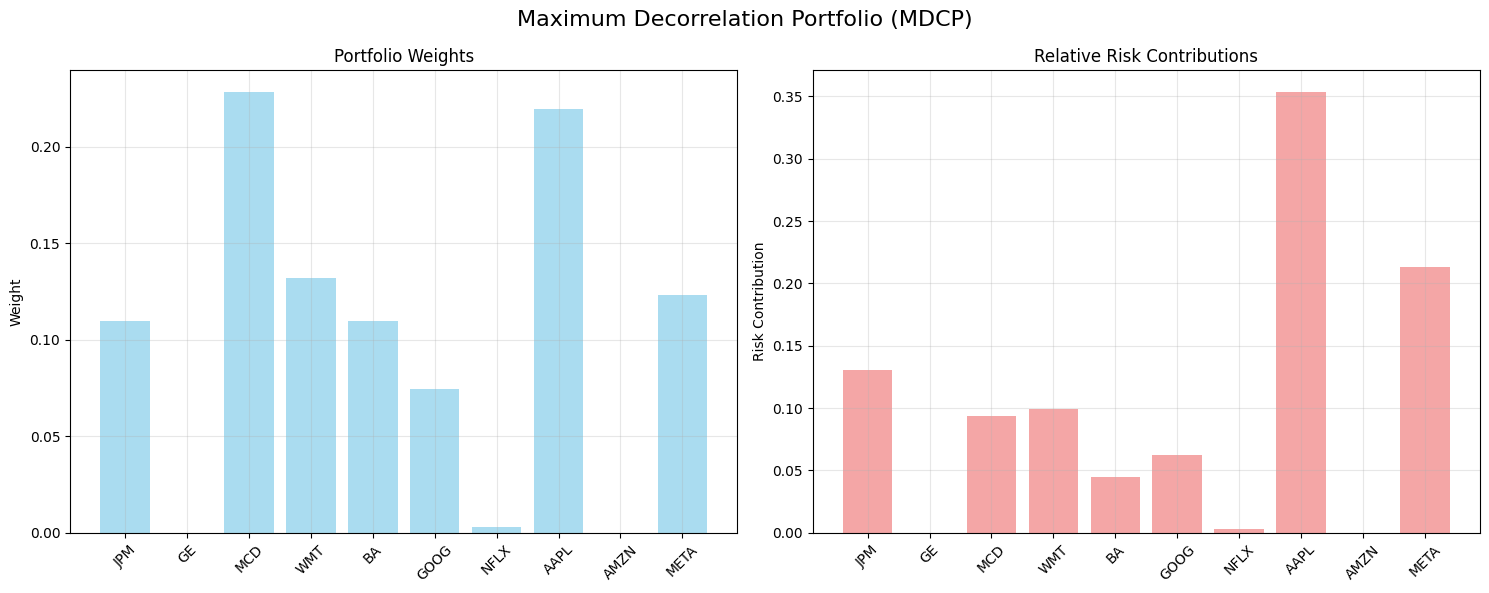

{'portfolio_volatility': np.float64(0.06056933258394145),
 'marginal_contribution': Ticker
 BA      0.072076
 GE      0.065363
 WMT     0.024877
 JPM     0.045634
 MCD     0.024638
 GOOG    0.050268
 AMZN    0.064658
 META    0.097461
 AAPL    0.044130
 NFLX    0.104923
 dtype: float64,
 'risk_contribution': Ticker
 BA      7.893077e-03
 GE      1.131129e-23
 WMT     5.677010e-03
 JPM     6.014467e-03
 MCD     2.709476e-03
 GOOG    3.757697e-03
 AMZN    1.968472e-04
 META    2.139460e-02
 AAPL    0.000000e+00
 NFLX    1.292615e-02
 dtype: float64,
 'relative_risk_contribution': Ticker
 BA      1.303147e-01
 GE      1.867495e-22
 WMT     9.372746e-02
 JPM     9.929888e-02
 MCD     4.473346e-02
 GOOG    6.203960e-02
 AMZN    3.249949e-03
 META    3.532250e-01
 AAPL    0.000000e+00
 NFLX    2.134109e-01
 dtype: float64}

In [32]:
def maximum_decorrelation_portfolio(Sigma):
    """
    Calculate Maximum Decorrelation Portfolio (MDCP)
    This is GMVP applied to the correlation matrix instead of covariance matrix
    """
    # Create correlation matrix
    vol = np.sqrt(np.diag(Sigma))
    # Correlation matrix C = D^(-1/2) * Sigma * D^(-1/2)
    # where D is diagonal matrix of variances
    D_inv_sqrt = np.diag(1 / vol)
    C = D_inv_sqrt @ Sigma @ D_inv_sqrt
    
    # Apply GMVP to correlation matrix
    return global_minimum_variance_portfolio(C)

# Calculate MDCP weights
w_MDCP = maximum_decorrelation_portfolio(Sigma)

print("Maximum Decorrelation Portfolio (MDCP) weights:")
mdcp_df = pd.DataFrame({'Weight': w_MDCP}, index=stock_list)
print(mdcp_df.round(4))

# Calculate portfolio metrics
portfolio_vol_mdcp = np.sqrt(w_MDCP.T @ Sigma @ w_MDCP)
portfolio_ret_mdcp = w_MDCP.T @ mu

# Calculate average correlation
vol = np.sqrt(np.diag(Sigma))
D_inv_sqrt = np.diag(1 / vol)
C = D_inv_sqrt @ Sigma @ D_inv_sqrt

# Portfolio correlation (weighted average correlation)
portfolio_corr = (w_MDCP.T @ C @ w_MDCP - np.sum(w_MDCP**2)) / (1 - np.sum(w_MDCP**2))

print(f"\nPortfolio volatility (weekly): {portfolio_vol_mdcp:.6f}")
print(f"Portfolio volatility (annualized): {portfolio_vol_mdcp * np.sqrt(52):.4f}")
print(f"Portfolio expected return (weekly): {portfolio_ret_mdcp:.6f}")
print(f"Portfolio expected return (annualized): {portfolio_ret_mdcp * 52:.4f}")

print(f"\nAverage pairwise correlation in portfolio: {portfolio_corr:.4f}")
print("(Lower correlation indicates better diversification)")

# Plot
plot_risk_contributions(w_MDCP, Sigma, stock_list, 'Maximum Decorrelation Portfolio (MDCP)')

Portfolio Weights Comparison:
      Inverse Volatility (IVP)  Naive RPP  Vanilla RPP  Risk Based Portfolio  \
JPM                     0.0714     0.0714       0.1121                0.2094   
GE                      0.0855     0.0855       0.0709                0.1535   
MCD                     0.1526     0.1526       0.1688                0.3107   
WMT                     0.1106     0.1106       0.1920                0.4802   
BA                      0.1667     0.1667       0.0703               -0.1538   
GOOG                    0.1040     0.1040       0.0939                0.0000   
NFLX                    0.0856     0.0856       0.0492                0.0000   
AAPL                    0.0607     0.0607       0.0944                0.0000   
AMZN                    0.1093     0.1093       0.0739                0.0000   
META                    0.0536     0.0536       0.0744                0.0000   

      Max Sharpe Ratio (MSRP)  Most Diversified (MDP)  \
JPM                    0.0000   

<Figure size 1500x1000 with 0 Axes>

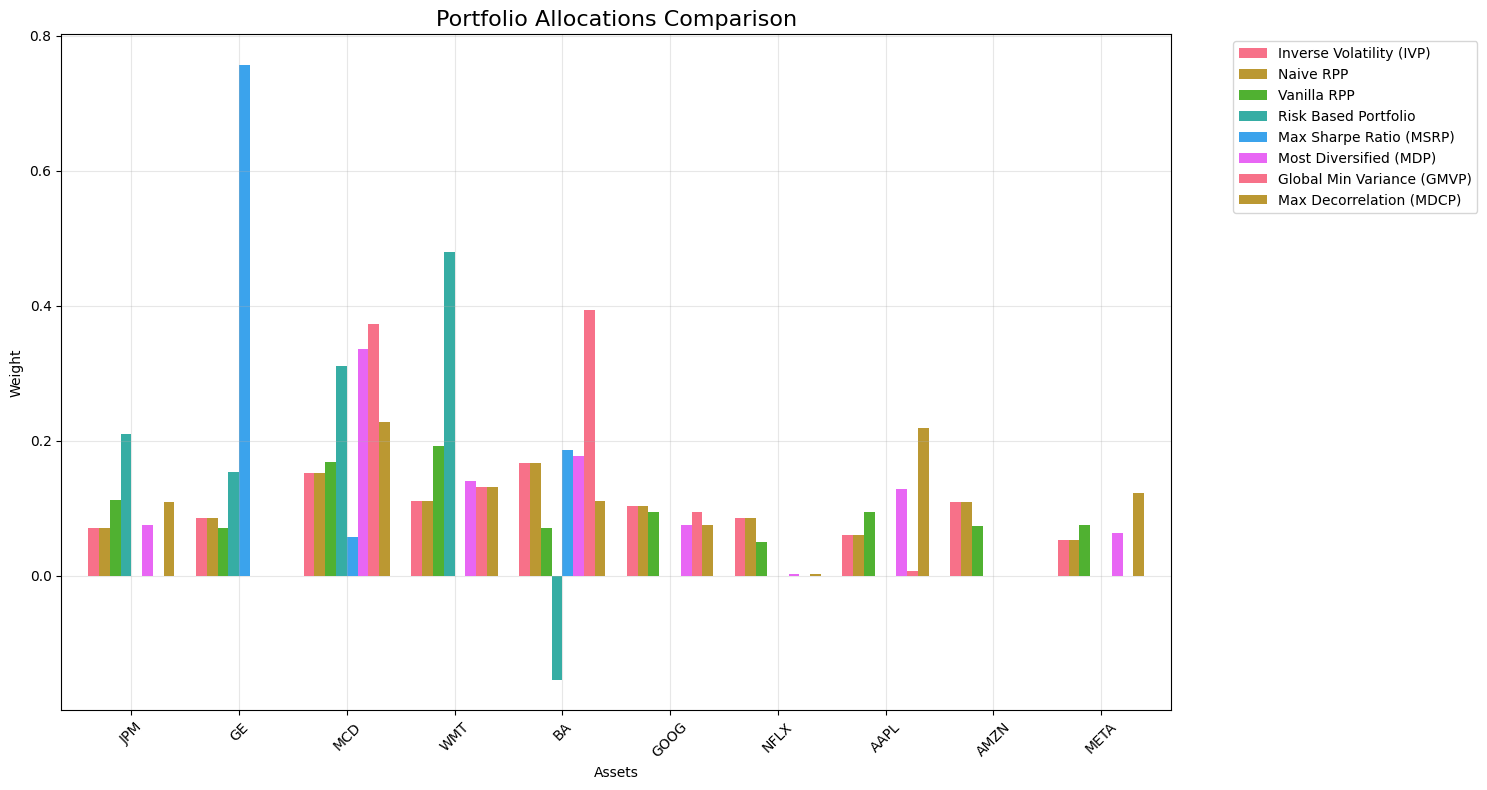


PORTFOLIO PERFORMANCE COMPARISON
                            Expected Return (Annual)  Volatility (Annual)  \
Inverse Volatility (IVP)                      0.4800               0.3930   
Naive RPP                                     0.4800               0.3930   
Vanilla RPP                                   0.4653               0.4173   
Risk Based Portfolio                          0.5412               0.4645   
Max Sharpe Ratio (MSRP)                       1.2111               0.5622   
Most Diversified (MDP)                        0.3797               0.3548   
Global Min Variance (GMVP)                    0.4265               0.2924   
Max Decorrelation (MDCP)                      0.3681               0.4368   

                            Sharpe Ratio  Risk Concentration (Std of RRC)  
Inverse Volatility (IVP)          0.1694                           0.0157  
Naive RPP                         0.1694                           0.0157  
Vanilla RPP                       0.1546    

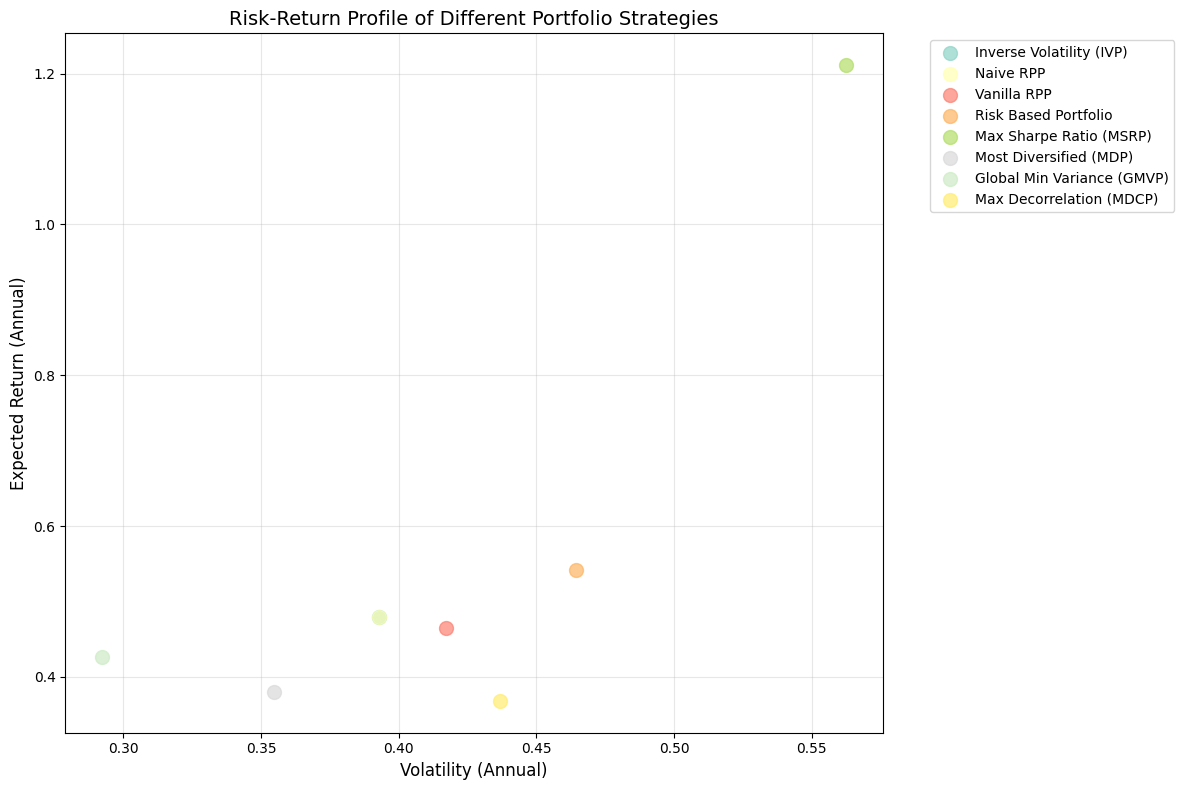

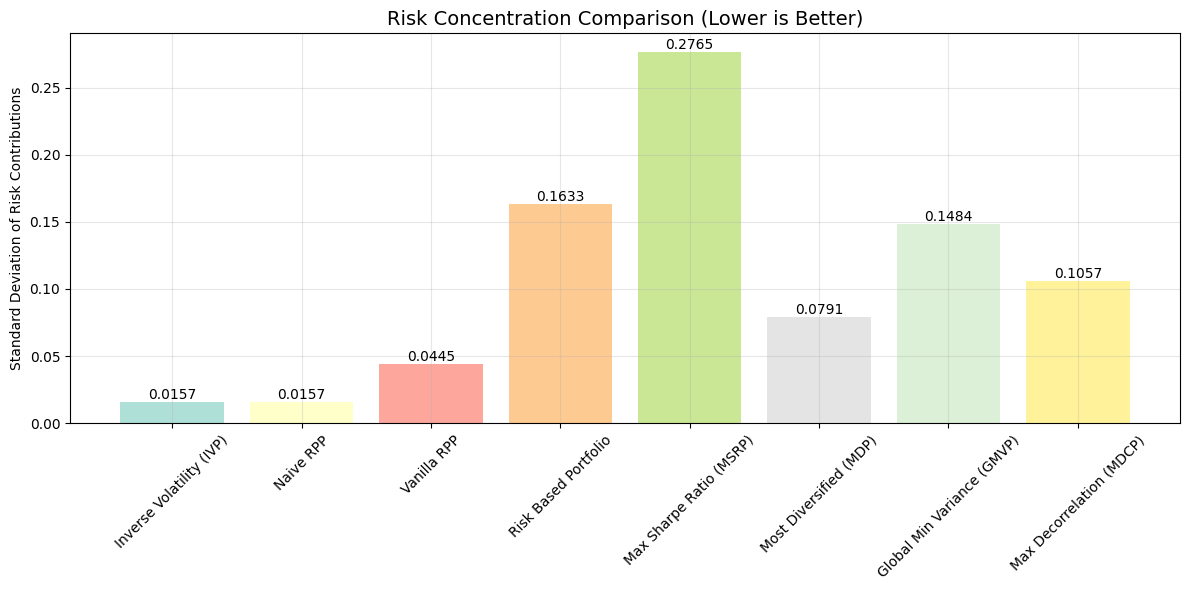


KEY INSIGHTS
• Highest Expected Return: Max Sharpe Ratio (MSRP)
  Return: 1.2111
• Lowest Risk (Volatility): Global Min Variance (GMVP)
  Volatility: 0.2924
• Highest Sharpe Ratio: Max Sharpe Ratio (MSRP)
  Sharpe: 0.2987
• Best Risk Diversification: Inverse Volatility (IVP)
  Risk Concentration: 0.0157

Most Concentrated Portfolio: Max Sharpe Ratio (MSRP)
Weights: {'JPM': 0.0, 'GE': 0.756, 'MCD': 0.057, 'WMT': 0.0, 'BA': 0.187, 'GOOG': 0.0, 'NFLX': 0.0, 'AAPL': 0.0, 'AMZN': 0.0, 'META': 0.0}

Least Concentrated Portfolio: Inverse Volatility (IVP)
Weights: {'JPM': 0.071, 'GE': 0.086, 'MCD': 0.153, 'WMT': 0.111, 'BA': 0.167, 'GOOG': 0.104, 'NFLX': 0.086, 'AAPL': 0.061, 'AMZN': 0.109, 'META': 0.054}


In [34]:
# Collect all portfolio weights for comparison
portfolios = {
    'Inverse Volatility (IVP)': w_IVP,
    'Naive RPP': w_RPP_naive,
    'Vanilla RPP': w_RPP,
    'Risk Based Portfolio': w_RBP,
    'Max Sharpe Ratio (MSRP)': w_MSRP,
    'Most Diversified (MDP)': w_MDP,
    'Global Min Variance (GMVP)': w_GMVP,
    'Max Decorrelation (MDCP)': w_MDCP
}

# Normalize weights to pandas Series indexed by stock_list so lengths match
import warnings

normalized = {}
for name, weights in portfolios.items():
    # If it's already a Series, reindex to the master stock list (fill missing with 0)
    if isinstance(weights, pd.Series):
        s = weights.reindex(stock_list).fillna(0.0)
    else:
        # convert arrays/lists to numpy array
        arr = np.asarray(weights)
        if arr.shape[0] == len(stock_list):
            s = pd.Series(arr, index=stock_list)
        else:
            # If the weight vector is shorter, align it to the first n tickers and fill the rest with zeros.
            warnings.warn(
                f"Weight vector for '{name}' has length {arr.shape[0]} != {len(stock_list)}. "
                "Aligning values to the first tickers and filling missing assets with 0."
            )
            s = pd.Series(arr, index=stock_list[:arr.shape[0]]).reindex(stock_list).fillna(0.0)
    normalized[name] = s

# Create comparison DataFrame (all columns now have index = stock_list)
comparison_df = pd.DataFrame(normalized)
print("Portfolio Weights Comparison:")
print(comparison_df.round(4))

# Plot comparison
plt.figure(figsize=(15, 10))
comparison_df.plot(kind='bar', width=0.8, figsize=(15, 8))
plt.title('Portfolio Allocations Comparison', fontsize=16)
plt.xlabel('Assets')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate portfolio metrics for all portfolios
portfolio_metrics = {}
for name in normalized.keys():
    w = comparison_df[name].values  # guaranteed numpy array of length len(stock_list)
    ret = w.T @ mu
    vol = np.sqrt(w.T @ Sigma @ w)
    sharpe = ret / vol if vol > 0 else 0

    # Risk contributions (use pandas Series input expected by portfolio_risk_contribution if needed)
    risk_data = portfolio_risk_contribution(pd.Series(w, index=stock_list), Sigma)
    rrc_std = np.std(risk_data['relative_risk_contribution'])  # Risk concentration measure

    portfolio_metrics[name] = {
        'Expected Return (Annual)': ret * 52,
        'Volatility (Annual)': vol * np.sqrt(52),
        'Sharpe Ratio': sharpe,
        'Risk Concentration (Std of RRC)': rrc_std
    }

# Create metrics comparison DataFrame
metrics_df = pd.DataFrame(portfolio_metrics).T
print("\n" + "="*80)
print("PORTFOLIO PERFORMANCE COMPARISON")
print("="*80)
print(metrics_df.round(4))

# Plot risk-return scatter
plt.figure(figsize=(12, 8))
returns = [metrics_df.loc[name, 'Expected Return (Annual)'] for name in normalized.keys()]
vols = [metrics_df.loc[name, 'Volatility (Annual)'] for name in normalized.keys()]
names = list(normalized.keys())

colors = plt.cm.Set3(np.linspace(0, 1, len(names)))
for i, (name, ret, vol) in enumerate(zip(names, returns, vols)):
    plt.scatter(vol, ret, s=100, c=[colors[i]], alpha=0.7, label=name)

plt.xlabel('Volatility (Annual)', fontsize=12)
plt.ylabel('Expected Return (Annual)', fontsize=12)
plt.title('Risk-Return Profile of Different Portfolio Strategies', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Risk concentration comparison
plt.figure(figsize=(12, 6))
risk_concentrations = [metrics_df.loc[name, 'Risk Concentration (Std of RRC)'] for name in normalized.keys()]
bars = plt.bar(names, risk_concentrations, alpha=0.7, color=colors)
plt.title('Risk Concentration Comparison (Lower is Better)', fontsize=14)
plt.ylabel('Standard Deviation of Risk Contributions')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, risk_concentrations):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"• Highest Expected Return: {metrics_df['Expected Return (Annual)'].idxmax()}")
print(f"  Return: {metrics_df['Expected Return (Annual)'].max():.4f}")

print(f"• Lowest Risk (Volatility): {metrics_df['Volatility (Annual)'].idxmin()}")  
print(f"  Volatility: {metrics_df['Volatility (Annual)'].min():.4f}")

print(f"• Highest Sharpe Ratio: {metrics_df['Sharpe Ratio'].idxmax()}")
print(f"  Sharpe: {metrics_df['Sharpe Ratio'].max():.4f}")

print(f"• Best Risk Diversification: {metrics_df['Risk Concentration (Std of RRC)'].idxmin()}")
print(f"  Risk Concentration: {metrics_df['Risk Concentration (Std of RRC)'].min():.4f}")

# Show most and least concentrated portfolios
most_concentrated = metrics_df['Risk Concentration (Std of RRC)'].idxmax()
least_concentrated = metrics_df['Risk Concentration (Std of RRC)'].idxmin()

print(f"\nMost Concentrated Portfolio: {most_concentrated}")
print("Weights:", comparison_df[most_concentrated].round(3).to_dict())

print(f"\nLeast Concentrated Portfolio: {least_concentrated}")  
print("Weights:", comparison_df[least_concentrated].round(3).to_dict())